In [2]:
# !pip install pystan==2.19.1.1
# !pip install prophet
# !pip install plotly

In [57]:
# Python
import pandas as pd
from prophet import Prophet

In [69]:
path = '/home/dazai/Documents/Data challenge/Data/Aggregated'
df_data = pd.read_feather(f"{path}/2016_street.feather")
df_data = df_data.drop(columns=['index'])
# df_data = df_data.iloc[:30000]
df_test = pd.read_feather(f"{path}/2017_street.feather")
df_test = df_test.drop(columns=['index'])
df_data

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
0,None,2016-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.511927,51.409435,On or near Harlech Close,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,None,NaN
1,None,2016-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.495055,51.422132,On or near Cross Street,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,None,NaN
2,2163e1bf85d197a93f9c1c6daeb113ad0e0fbd3a8b603f...,2016-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.513308,51.409456,On or near Charlton Road,E01014399,Bath and North East Somerset 001A,Burglary,Under investigation,NaN
3,74f4fc07b60510a8862f77180de1c8bf1a0755105ec494...,2016-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.511761,51.409966,On or near Caernarvon Close,E01014399,Bath and North East Somerset 001A,Burglary,Under investigation,NaN
4,6c3dbed2ea67ad837bee1229ccf3951bd48f42e22421fe...,2016-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.511927,51.409435,On or near Harlech Close,E01014399,Bath and North East Somerset 001A,Other theft,Under investigation,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
6044341,b43cb11b603aa76d23e4552328bff91c16376b1e533ea4...,2016-12,Wiltshire Police,Wiltshire Police,-1.720591,50.988050,On or near Orchard Road,E01031994,Wiltshire 062D,Other theft,Investigation complete; no suspect identified,NaN
6044342,5914399e9b4fdeabc7f648e2a29c6d44715ae856bf823c...,2016-12,Wiltshire Police,Wiltshire Police,-1.744812,50.993204,On or near Church Leat,E01031995,Wiltshire 062E,Other theft,Investigation complete; no suspect identified,NaN
6044343,ef3afa4801504a3ccce5cd9eda96e45956ce85b56133d7...,2016-12,Wiltshire Police,Wiltshire Police,-1.759025,50.994654,On or near Petrol Station,E01031995,Wiltshire 062E,Other theft,Investigation complete; no suspect identified,NaN
6044344,8e49488d61f397bbf4d4610fb8a2e748a2a7e2e7832bd4...,2016-12,Wiltshire Police,Wiltshire Police,-1.751553,50.992849,On or near The Borough,E01031995,Wiltshire 062E,Violence and sexual offences,Under investigation,NaN


In [62]:
print(df_data['Falls within'].value_counts())
df_data['Falls within'].value_counts().mean()



Metropolitan Police Service           994529
Greater Manchester Police             362115
West Yorkshire Police                 303681
West Midlands Police                  259860
South Yorkshire Police                192444
Hampshire Constabulary                185162
Northumbria Police                    180630
Lancashire Constabulary               179220
Thames Valley Police                  172866
Kent Police                           171787
Avon and Somerset Constabulary        171701
Essex Police                          170748
Merseyside Police                     159851
Police Service of Northern Ireland    157414
Sussex Police                         140543
South Wales Police                    133459
Devon & Cornwall Police               127428
West Mercia Police                    120770
Nottinghamshire Police                114894
Staffordshire Police                  113260
Hertfordshire Constabulary            102827
Derbyshire Constabulary                95401
Cleveland 

134318.8

In [74]:
district = df_data[df_data['Falls within']=='South Wales Police']
predict = {}

district = district.sort_values(by=['Month'])
months = district['Month'].unique()
for i in months:
    predict[i] = len(district[district['Month']==i])
predict = pd.DataFrame({'ds': list(predict.keys()), 'y': list(predict.values())})

In [78]:
predict['ds'] = pd.to_datetime(predict['ds'])


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.



Initial log joint probability = -0.863243
Iteration  1. Log joint probability =    3.67635. Improved by 4.53959.
Iteration  2. Log joint probability =    24.4924. Improved by 20.816.
Iteration  3. Log joint probability =    28.0614. Improved by 3.56903.
Iteration  4. Log joint probability =    28.8393. Improved by 0.777884.
Iteration  5. Log joint probability =     29.973. Improved by 1.13376.
Iteration  6. Log joint probability =    30.0083. Improved by 0.0352547.
Iteration  7. Log joint probability =    30.0528. Improved by 0.0444698.
Iteration  8. Log joint probability =    30.0751. Improved by 0.0223805.
Iteration  9. Log joint probability =    30.0791. Improved by 0.00397751.
Iteration 10. Log joint probability =    30.1081. Improved by 0.0289695.
Iteration 11. Log joint probability =    30.1578. Improved by 0.0497541.
Iteration 12. Log joint probability =    30.1928. Improved by 0.0349364.
Iteration 13. Log joint probability =    30.2135. Improved by 0.0207364.
Iteration 14. Log

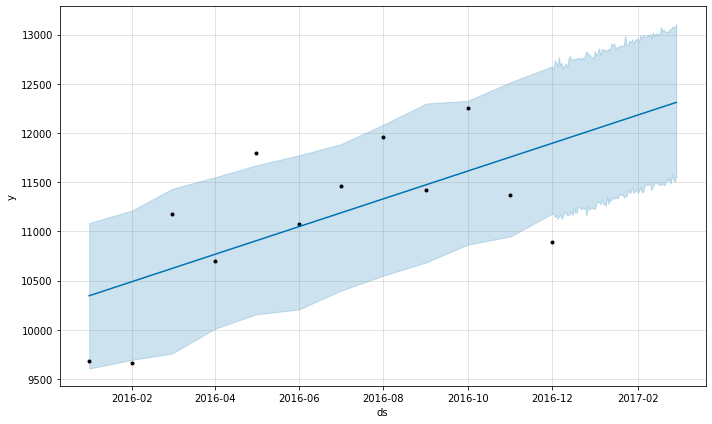

In [83]:
# m = Prophet()
# m.fit(predict)

m = Prophet(seasonality_mode='multiplicative').fit(predict)
future = m.make_future_dataframe(periods=90)
fcst = m.predict(future)
fig = m.plot(fcst)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.





Gradient evaluation took 3e-05 secondsGradient evaluation took 2.7e-05 secondsGradient evaluation took 2.9e-05 seconds


1000 transitions using 10 leapfrog steps per transition would take 0.29 seconds.1000 transitions using 10 leapfrog steps per transition would take 0.27 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.3 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!
Adjust your expectations accordingly!








Gradient evaluation took 2.9e-05 seconds
Iteration:   1 / 300 [  0%]  (Warmup)
1000 transitions using 10 leapfrog steps per transition would take 0.29 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 300 [  0%]  (Warmup)
Iteration:   1 / 300 [  0%]  (Warmup)
Iteration:   1 / 300 [  0%]  (Warmup)
Iteration:  30 / 300 [ 10%]  (Warmup)
Iteration:  30 / 300 [ 10%]  (Warmup)
Iteration:  30 / 300 [ 10%]  (Warmup)
Iteration:  60 / 300 [ 20%]  (Warmup)
Iteration:  30 / 300 [ 10%]  (Warmup)
Iteration

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



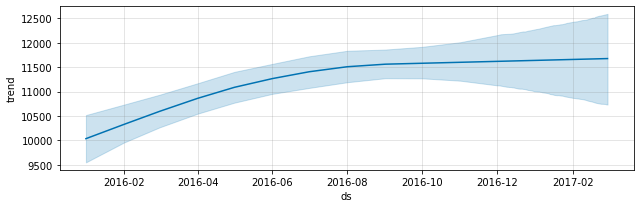

In [84]:
m = Prophet(seasonality_mode='multiplicative', mcmc_samples=300).fit(predict)
fcst = m.predict(future)
fig = m.plot_components(fcst)

In [80]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3659,2026-11-27,28754.505085,27986.772338,29561.662701
3660,2026-11-28,28759.126610,28029.593583,29590.938167
3661,2026-11-29,28763.748134,28047.400132,29499.106403
3662,2026-11-30,28768.369658,27951.327102,29542.228971
3663,2026-12-01,28772.991183,28011.821883,29544.202383


In [52]:
# df_predict = df_data[~df_data.isna()]
# df_predict

In [53]:
# df_data.loc[[129657]]

In [54]:
# df_predict = df_data[['Month', 'Longitude', 'Latitude']].reset_index()
# index = df_predict.pop('index')
# df_predict.insert(1, 'index', index)


# df_predict.columns = ['ds', 'y', 'add1', 'add2']

# df_predict
